# Symbol-wise Autoencoder


# Import lib

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense, Softmax

## Define the layers

1) Photon propagation over a distance $d = - \frac{ln(U)}{c(\lambda)} $ , $U$ is a uniformly distributed random number, $c(\lambda)$ is the extinction coefficient
2) Updating direction of photon using scattering functions: $ \cos(\theta) = \frac{1}{2g} \left( 1 + g^2 - \left( \frac{1 - g^2}{1 - g + 2gU} \right)^2 \right) $ where $\theta$ is the new scattering angle, $g$ is the asymmetry parameter
3) Absorption to reduce the weight of the photon $ \text{weightPh}= \text{weightPh} \cdot e^{−aU⋅d}$
4) Channel impulse response $h_t = \frac{I_{\text{received}}}{I_{\text{total}}}$, where $I$ is the intensity.
5) Received signal is calculated after adding noise based on SNR $ReceivedSamples = h \cdot OutputSamples + Noise$

In [9]:
### Implementation of UWOC_channel received from Dr. Mustafa
class UWOCChannel(tf.Module):
    def __init__(self, aU, bU, cU, Nt, Nr, FlipFlag):
        self.aU = aU
        self.bU = bU
        self.cU = cU
        self.Nt = Nt
        self.Nr = Nr
        self.FlipFlag = FlipFlag
        
        self.Fov = tf.constant(120 * (3.1415926535 / 180), dtype=tf.float32)
        self.n_water = tf.constant(1.333, dtype=tf.float32)
        self.v = 3e8 / self.n_water
        self.roulette_constant = tf.constant(1.0, dtype=tf.float32)
        
        self.photons_received = tf.Variable(0, dtype=tf.float32, trainable=False)
        self.total_intensity = tf.Variable(0.0, dtype=tf.float32, trainable=False)

    @tf.function
    def initialize_photon(self, receiver_position):
        positionPh = tf.zeros(3, dtype=tf.float32)
        direction_vector = receiver_position - positionPh
        normalized_direction = direction_vector / tf.norm(direction_vector)
        # tf.print("Photon direction:", normalized_direction)  # Debug print
    
        thetaPh = tf.acos(normalized_direction[2])
        phiPh = tf.atan2(normalized_direction[1], normalized_direction[0])
        directionPh = normalized_direction
    
        weightPh = tf.constant(1.0, dtype=tf.float32)
        return thetaPh, phiPh, positionPh, directionPh, weightPh


    @tf.function
    def move_photon(self, d, positionPh, directionPh):
        return positionPh + d * directionPh

    @tf.function
    def received(self, positionRe, radiusRe, positionPh, directionPh, positionPh_new):
        distance = tf.norm(positionPh_new - positionRe)
        reached = distance <= radiusRe
    
        if reached:
            direction_to_receiver = positionRe - positionPh_new
            direction_to_receiver = direction_to_receiver / tf.norm(direction_to_receiver)
            cos_angle = tf.tensordot(directionPh, direction_to_receiver, axes=1)
            within_fov = cos_angle > tf.cos(self.Fov / 2)
            return reached, positionPh_new, within_fov
        else:
            return reached, positionPh_new, False

    @tf.function
    def simulate(self, OutputSamples, snr):
        N = tf.constant(1000, dtype=tf.int32)
        photons_received = tf.TensorArray(dtype=tf.float32, size=N)
        total_intensity = tf.TensorArray(dtype=tf.float32, size=N)
        receiver_position = tf.constant([5.0, 0.0, 0.0], dtype=tf.float32)
        receiver_radius = tf.constant(10.0, dtype=tf.float32)
    
        for i in tf.range(N):
            thetaPh, phiPh, positionPh, directionPh, weightPh = self.initialize_photon(receiver_position)
            reached = tf.constant(False, dtype=tf.bool)
    
            while tf.logical_and(tf.logical_not(reached), weightPh > 0):
                d = -tf.math.log(tf.random.uniform([], dtype=tf.float32)) / self.cU
                positionPh_new = self.move_photon(d, positionPh, directionPh)
    
                reached, positionPh_new, within_fov = self.received(receiver_position, receiver_radius, positionPh, directionPh, positionPh_new)
                # tf.print("Photon position:", positionPh_new, "Weight:", weightPh, "Reached:", reached, "Within FOV:", within_fov)  # Debug print
    
                if reached and within_fov:
                    photons_received = photons_received.write(i, 1)
                    total_intensity = total_intensity.write(i, weightPh)
                    break
    
                weightPh = weightPh * tf.exp(-self.aU * d)
    
                if weightPh < 1e-2:
                    survival_prob = tf.random.uniform([], dtype=tf.float32)
                    if survival_prob > 0.1:
                        weightPh = tf.constant(0.0, dtype=tf.float32)
                    else:
                        weightPh = weightPh / tf.constant(0.1, dtype=tf.float32)
    
                positionPh = positionPh_new
    
        total_received = tf.reduce_sum(photons_received.stack())
        total_intensity_value = tf.reduce_sum(total_intensity.stack())
    
        h_t_N = total_intensity_value / tf.cast(N, tf.float32)
        h_t = tf.ones_like(OutputSamples) * tf.cast(h_t_N, tf.complex64)
        UWOC_receivedSig = OutputSamples * h_t
    
        snr = tf.cast(snr, tf.float32)
        noise_stddev = tf.sqrt(2 / tf.pow(10., snr / 10.0))
        noise_r = tf.random.normal(shape=tf.shape(UWOC_receivedSig), stddev=1) * noise_stddev / tf.sqrt(2.)
        noise_i = tf.random.normal(shape=tf.shape(UWOC_receivedSig), stddev=1) * noise_stddev / tf.sqrt(2.)
        noise_cplx = tf.complex(noise_r, noise_i, name="noise")
    
        ReceivedSamples = UWOC_receivedSig + noise_cplx
    
        # tf.print("Final photons received:", total_received, "total_intensity_value:", total_intensity_value)
    
        if self.FlipFlag:
            ReceivedSamples = tf.transpose(ReceivedSamples)
    
        return ReceivedSamples

In [3]:
class Normalization(Layer):

    def __init__(self, **kwargs):
        super(Normalization, self).__init__(**kwargs)

    def call(self, symbols):
        # Normalize power per symbol to 1
        en_moy = tf.sqrt(2 * tf.reduce_mean(tf.square(symbols)))
        symbols_norm = tf.divide(symbols, en_moy)

        return symbols_norm

class R2C(Layer):

    def __init__(self, **kwargs):
        super(R2C, self).__init__(**kwargs)

    def call(self, x):
        # Converts 2Nc real numbers into Nc complex numbers
        x_cplx = tf.complex(x[:, :1], x[:, 1:])

        return x_cplx

class C2R(Layer):

    def __init__(self, **kwargs):
        super(C2R, self).__init__(**kwargs)

    def call(self, y):
        #converts Nc complex numbers into 2Nc real numbers
        y_real = tf.concat([tf.math.real(y), tf.math.imag(y)], axis=1)

        return y_real

class OneHot(Layer):

    def __init__(self, M, **kwargs):
        super(OneHot, self).__init__(**kwargs)
        self.M = M

    def call(self, msg):

        one_hot_msg = tf.one_hot(msg, depth = M)

        return one_hot_msg

class Channel(Layer):

    def __init__(self, **kwargs):
        super(Channel, self).__init__(**kwargs)

    def call(self, x, snr): #snr is the second positional argument
        # Adds random Gaussian noise to the input
        # Cast snr to float32 to ensure type consistency
        snr = tf.cast(snr, tf.float32)
        noise_stddev = tf.sqrt( 2 / tf.pow(10., snr/10.0))
        noise_r = tf.random.normal(shape = tf.shape(x), stddev = 1) * noise_stddev/tf.sqrt(2.)
        noise_i = tf.random.normal(shape = tf.shape(x), stddev = 1) * noise_stddev/tf.sqrt(2.)
        noise_cplx = tf.complex(noise_r, noise_i, name="noise")

        return x  + noise_cplx

## Generate messages

In [4]:
def generate_ds_msg(epoch_len, batch_size, M):

    #Generate a dataset of 'epoch_len' batches of messages.
    #Each batch have a size 'batch_size' and consists of messages (symbols) betwen 0 and M-1
    rand_msg = tf.random.uniform(shape=[epoch_len, batch_size], minval=0, maxval=M, dtype=tf.int32)
    features_ds = tf.data.Dataset.from_tensor_slices(rand_msg)

    #The labels are the same as the features : this is an autoencoder, we want to predict the same message that has been sent.
    labels_ds = features_ds

    return (features_ds, labels_ds)

## Define the model

In [10]:
class Autoencoder(Model):

    def __init__(self, M, aU, bU, cU, Nt, Nr, FlipFlag, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)

        #Set the class' attributes
        self.M = M
        self.aU = aU
        self.bU = bU
        self.cU = cU
        self.Nt = Nt
        self.Nr = Nr
        self.FlipFlag = FlipFlag

        # Initialise the transmitter layers
        self.oh = OneHot(self.M)
        self.d1 = Dense(64, activation='elu')
        self.d2 = Dense(2, activation=None)
        self.norm = Normalization()
        self.r2c = R2C()

        # Initialise the channel
        # self.ch = Channel(self.M)
        self.ch = UWOCChannel(self.aU, self.bU, self.cU, self.Nt, self.Nr, self.FlipFlag)

        # Initialise the receiver layers
        self.c2r = C2R()
        self.d3 = Dense(64, activation='elu')
        self.d4 = Dense(self.M, activation=None)
        self.softm = Softmax()

    def call(self, inputs, snr):

        # Transmitter
        self.x1 = self.oh(inputs)
        self.x2 = self.d1(self.x1)
        self.x3 = self.d2(self.x2)
        self.x4 = self.norm(self.x3)
        self.x = self.r2c(self.x4)

        #Channel
        # self.y = self.ch(self.x, snr=snr) 
        self.y = self.ch.simulate(self.x, snr)

        #Receiver
        self.pb1 = self.c2r(self.y)
        self.pb2 = self.d3(self.pb1)
        self.pb3 = self.d4(self.pb2)
        self.pb = self.softm(self.pb3)

        return self.pb

## loss function

In [6]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()

## Instantiate the autoencoder

In [11]:
# Number of messages
M = 4
#Set the seeds
SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)

aU, bU = 0.1, 0.1
cU = aU + bU
Nt, Nr = 1, 1
FlipFlag = False

#Create the autoencoder
autoencoder = Autoencoder(M, aU, bU, cU, Nt, Nr, FlipFlag)

# See constellation before training

Final photons received: 644
total_received: 644 total_intensity_value: 644


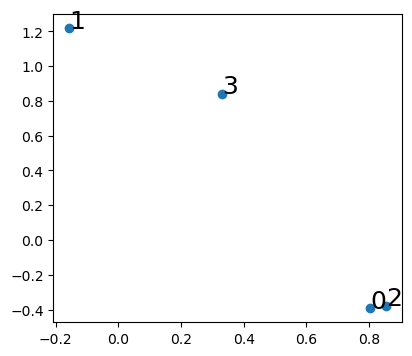

In [8]:
snr_eval = 10

# Form a batch containing every message
batch_msg = tf.cast(tf.linspace(0., M-1, M), tf.int32)

p_b = autoencoder(batch_msg, snr=snr_eval)

msg_np = batch_msg.numpy()
x_np = autoencoder.x.numpy()

plt.figure(figsize=(4.5, 4))
plt.scatter(np.real(x_np[:, 0]), np.imag(x_np[:, 0]))
for i in range(np.shape(x_np)[0]) :
    plt.text(np.real(x_np[i, 0]), np.imag(x_np[i, 0]), str(msg_np[i]), fontsize=18)

# Train

In [12]:
batch_size = 10000
epoch_size = 100
nb_epoch = 25
snr_training = 15

print('Symbol Error Rate after each epoch:')

#Initialize optimizer
optimizer = tf.keras.optimizers.Adam()

for epoch in range(nb_epoch):

    # Create a random dataset for each epoch
    dataset = tf.data.Dataset.zip(generate_ds_msg(epoch_size, batch_size, M))

    # Iterate over the batches of the dataset.
    for step, (features, labels) in enumerate(dataset):
        # Open a GradientTape.
        with tf.GradientTape() as tape:

            # Forward pass.
            probas = autoencoder(features, snr=snr_training)

            # Loss value for this batch.
            loss_value =  loss_func(y_true=labels, y_pred=probas)

        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, autoencoder.trainable_weights)

        # Update the weights of our linear layer.
        optimizer.apply_gradients(zip(gradients, autoencoder.trainable_weights))

    #Take the argmax of the probability distribution as the estimated message
    m_hat = tf.argmax(probas, axis=1, output_type=tf.int32)

    ser = tf.reduce_sum(tf.clip_by_value(tf.abs(labels-m_hat), 0, 1))/(batch_size)
    print(ser.numpy(), end=', ')
print('Done')

Symbol Error Rate after each epoch:
0.0614, 0.0125, 0.0144, 0.0103, 0.0105, 0.0124, 0.012, 0.0088, 0.0151, 0.0125, 0.0194, 0.01, 0.0109, 0.0151, 0.0108, 0.0124, 0.0126, 0.0126, 0.0149, 0.0101, 0.0147, 0.0112, 0.012, 0.0105, 0.0083, Done


## Evaluate the model

In [13]:
snr_range = np.arange(-5, 21, dtype=np.float32)
results=[]
bs_eval = 100000

for snr_eval in snr_range:

    batch_msg = tf.random.uniform(shape=[bs_eval], minval=0, maxval=M, dtype=tf.int32)

    p_m = autoencoder(batch_msg, snr_eval)
    m_hat = tf.argmax(p_m, axis=1, output_type=tf.int32)

    ser = tf.reduce_sum(tf.clip_by_value(tf.abs(batch_msg-m_hat), 0, 1))/(bs_eval)
    print(ser.numpy(), end=', ')
    results.append(ser.numpy())

0.63725, 0.63161, 0.61287, 0.59402, 0.57458, 0.55801, 0.51989, 0.48963, 0.46859, 0.42091, 0.3697, 0.33848, 0.28739, 0.25182, 0.2055, 0.15662, 0.1312, 0.07178, 0.04758, 0.02254, 0.01261, 0.00384, 0.00189, 0.00045, 6e-05, 2e-05, 

In [16]:
AE = np.array([0.63725, 0.63161, 0.61287, 0.59402, 0.57458, 0.55801, 0.51989, 0.48963, 0.46859, 0.42091, 0.3697, 0.33848, 0.28739, 0.25182, 0.2055, 0.15662, 0.1312, 0.07178, 0.04758, 0.02254, 0.01261, 0.00384, 0.00189, 0.00045, 6e-05, 2e-05])

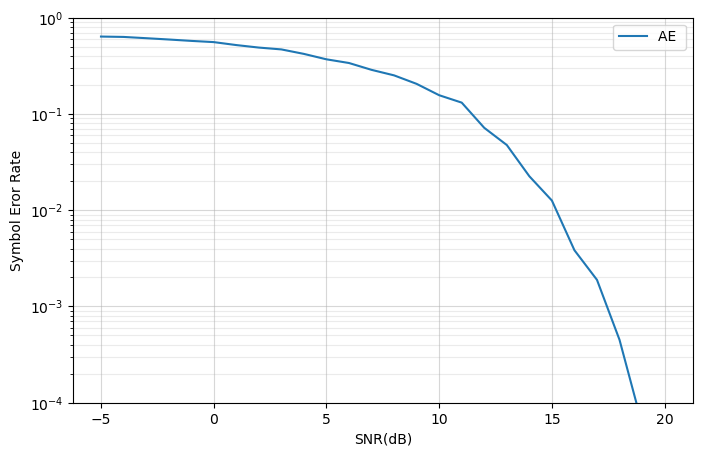

In [19]:
plt.figure(figsize=(8, 5))
plt.semilogy(snr_range, results, label='AE ')
# plt.semilogy(snr_range, results, label='AE 16-QAM')
plt.legend()
plt.xlabel('SNR(dB)')
plt.ylabel('Symbol Eror Rate');
plt.ylim(1e-4, 1)
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.25)

## See learned constellation

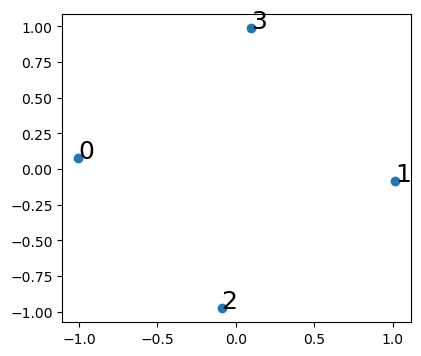

In [18]:
snr_eval = 10

# Form a batch containing every message
batch_msg = tf.cast(tf.linspace(0., M-1, M), tf.int32)

p_b = autoencoder(batch_msg, snr=snr_eval)

msg_np = batch_msg.numpy()
x_np = autoencoder.x.numpy()

plt.figure(figsize=(4.5, 4))
plt.scatter(np.real(x_np[:, 0]), np.imag(x_np[:, 0]))
for i in range(np.shape(x_np)[0]) :
    plt.text(np.real(x_np[i, 0]), np.imag(x_np[i, 0]), str(msg_np[i]), fontsize=18)